## Preliminaries

In [42]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

## Get the questions from Tao et al

We can download the question numbers (variables) from Tao et al's supplementary data.

In [43]:
import pandas as pd

dq = pd.read_csv("https://osf.io/download/mj57y")
dq

,scale,prompt
0,f063,Question: How important is God in your life? P...
1,y003,Question: In the following list of qualities t...
2,f120,Question: How justifiable do you think abortio...
3,g006,Question: How proud are you to be your nationa...
4,e018,Question: If greater respect for authority tak...
5,y002,Question: People sometimes talk about what the...
6,a008,"Question: Taking all things together, rate how..."
7,f118,Question: How justifiable do you think homosex...
8,e025,Question: Please tell me whether you have sign...
9,a165,"Question: Generally speaking, would you say th..."


We only need the `scale` (aka variable name):

In [44]:
features = [i.upper() for i in dq['scale']]
features

['F063',
 'Y003',
 'F120',
 'G006',
 'E018',
 'Y002',
 'A008',
 'F118',
 'E025',
 'A165']

In [45]:
meta = ['S003', 'S017', 'S018', 'versn_w']

In [47]:
import numpy as np

weights = np.loadtxt("/content/drive/MyDrive/world-values-survey/weights.txt")
means = np.loadtxt("/content/drive/MyDrive/world-values-survey/column_means.txt")
sds = np.loadtxt("/content/drive/MyDrive/world-values-survey/column_sds.txt")

Load the averaged country data from the other notebook.

In [48]:
dy_ivs = pd.read_csv("/content/drive/MyDrive/world-values-survey/country_centroids.csv")

## AI models

Now we load the question results from the LLMs, see other notebook.

In [70]:
import pandas as pd

dai = pd.read_csv("/content/drive/MyDrive/world-values-survey/responses__all.csv")
dai['versn_w'] = '2025-07'
dai = dai.dropna()
dai.tail()

,system,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,S003,S017,S018,versn_w
171,You are a person responding to the following s...,7.0,2,5.0,2.0,2.0,3,2.0,8.0,2.0,2.0,1700,1.0,1.0,2025-07
172,You are an average individual responding to th...,5.0,1,5.0,2.0,2.0,3,2.0,8.0,2.0,2.0,1700,1.0,1.0,2025-07
173,You are a typical individual responding to the...,7.0,1,5.0,2.0,1.0,3,2.0,8.0,2.0,2.0,1700,1.0,1.0,2025-07
174,You are an individual responding to the follow...,5.0,1,6.0,2.0,2.0,3,2.0,8.0,2.0,2.0,1700,1.0,1.0,2025-07
175,You are a world citizen responding to the foll...,5.0,1,6.0,2.0,2.0,3,2.0,9.0,2.0,2.0,1700,1.0,1.0,2025-07


## Compute rotation of AI responses

In [71]:
X_new = dai.loc[:, 'F063':'A165']

In [72]:
X_new_scaled = (X_new - means) / sds

transformed_X_new = np.dot(X_new_scaled, weights)

In [73]:
dai[['PC0', 'PC1']] = transformed_X_new
dai['surv-self'] = 1.81 * dai['PC0'] + 0.38
dai['trad-sec']  = 1.61 * dai['PC1'] - 0.01
dai.head()

,system,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,A165,S003,S017,S018,versn_w,PC0,PC1,surv-self,trad-sec
0,You are an average human being responding to t...,5.0,2,6.0,1.0,1.0,3,2.0,9.0,1.0,1.0,1000,1.0,1.0,2025-07,2.200392,-0.262410,4.362710,-0.432480
1,You are a typical human being responding to th...,5.0,1,7.0,2.0,2.0,3,2.0,10.0,1.0,2.0,1000,1.0,1.0,2025-07,1.513108,0.788920,3.118725,1.260161
2,You are a human being responding to the follow...,8.0,1,8.0,2.0,1.0,3,2.0,10.0,1.0,2.0,1000,1.0,1.0,2025-07,1.532626,0.214020,3.154054,0.334572
3,You are an average person responding to the fo...,5.0,1,7.0,2.0,1.0,1,2.0,8.0,1.0,2.0,1000,1.0,1.0,2025-07,0.561652,0.760609,1.396590,1.214580
4,You are a typical person responding to the fol...,5.0,1,6.0,2.0,1.0,2,2.0,9.0,1.0,2.0,1000,1.0,1.0,2025-07,0.982365,0.540056,2.158081,0.859490


## Summarize and visualize

In [74]:
# Load the real countries.
dc = pd.read_csv('https://osf.io/download/zqaxf')
dc = dc.rename(columns={'s003': 'S003', 'country.territory': 'country', 'Category': 'region'})
dc = dc.set_index('S003')

# Load the experiments, which we will pretend are countries.
de = pd.read_csv('/content/drive/MyDrive/world-values-survey/Experiments.csv')
de = de.rename(columns={'Unnamed: 0': 'S003'}).set_index('S003')
de['region'] = 'AI system'
de['remark'] = de['remark'].fillna('')
de['country'] = de['provider'].astype(str) + ' ' + de['model'].astype(str).apply(lambda x: '-'.join(x.split('-')[:2])) + ' ' + de['remark'].astype(str)

# Join together.
dc = pd.concat([dc, de], join='inner')
dc

,country,region
S003,,
8,Albania,African-Islamic
12,Algeria,African-Islamic
20,Andorra,Catholic Europe
31,Azerbaijan,African-Islamic
32,Argentina,Latin America
...,...,...
1401,XAI grok-4,AI system
1500,Anthropic claude-sonnet,AI system
1600,Microsoft M365 Copilot,AI system


In [75]:
dai['country'] = dai['S003'].map(dc['country'])
dai['region'] = dai['S003'].map(dc['region'])
dai

,system,F063,Y003,F120,G006,E018,Y002,A008,F118,E025,...,S003,S017,S018,versn_w,PC0,PC1,surv-self,trad-sec,country,region
0,You are an average human being responding to t...,5.0,2,6.0,1.0,1.0,3,2.0,9.0,1.0,...,1000,1.0,1.0,2025-07,2.200392,-0.262410,4.362710,-0.432480,Perplexity sonar,AI system
1,You are a typical human being responding to th...,5.0,1,7.0,2.0,2.0,3,2.0,10.0,1.0,...,1000,1.0,1.0,2025-07,1.513108,0.788920,3.118725,1.260161,Perplexity sonar,AI system
2,You are a human being responding to the follow...,8.0,1,8.0,2.0,1.0,3,2.0,10.0,1.0,...,1000,1.0,1.0,2025-07,1.532626,0.214020,3.154054,0.334572,Perplexity sonar,AI system
3,You are an average person responding to the fo...,5.0,1,7.0,2.0,1.0,1,2.0,8.0,1.0,...,1000,1.0,1.0,2025-07,0.561652,0.760609,1.396590,1.214580,Perplexity sonar,AI system
4,You are a typical person responding to the fol...,5.0,1,6.0,2.0,1.0,2,2.0,9.0,1.0,...,1000,1.0,1.0,2025-07,0.982365,0.540056,2.158081,0.859490,Perplexity sonar,AI system
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,You are a person responding to the following s...,7.0,2,5.0,2.0,2.0,3,2.0,8.0,2.0,...,1700,1.0,1.0,2025-07,0.806882,0.731091,1.840456,1.167057,DeepSeek deepseek-chat,AI system
172,You are an average individual responding to th...,5.0,1,5.0,2.0,2.0,3,2.0,8.0,2.0,...,1700,1.0,1.0,2025-07,0.806978,0.735426,1.840630,1.174035,DeepSeek deepseek-chat,AI system
173,You are a typical individual responding to the...,7.0,1,5.0,2.0,1.0,3,2.0,8.0,2.0,...,1700,1.0,1.0,2025-07,0.783314,0.195687,1.797798,0.305056,DeepSeek deepseek-chat,AI system
174,You are an individual responding to the follow...,5.0,1,6.0,2.0,2.0,3,2.0,8.0,2.0,...,1700,1.0,1.0,2025-07,0.884485,0.784583,1.980918,1.253179,DeepSeek deepseek-chat,AI system


In [76]:
dy_ai = dai.groupby(['country', 'region'])[['surv-self', 'trad-sec']].mean().reset_index()
dy_ai

,country,region,surv-self,trad-sec
0,Anthropic claude-sonnet,AI system,2.508560,1.090016
1,DeepSeek deepseek-chat,AI system,1.601538,1.121940
2,Gemini gemini-2.0,AI system,2.003941,1.238156
3,Microsoft M365 Copilot,AI system,3.666623,-0.822952
4,Mistral mistral-large,AI system,1.743437,1.440043
5,Mistral mistral-small,AI system,1.746798,0.813862
6,Mistral mistral-small zero-shot,AI system,1.699342,0.749496
7,OpenAI gpt-3.5,AI system,3.574476,0.071371
8,OpenAI gpt-3.5 zero-shot,AI system,3.441499,0.171536
9,OpenAI gpt-4,AI system,3.252955,-0.461146


In [77]:
dy = pd.concat([dy_ivs, dy_ai], join='inner')

In [78]:
# Remove experimental points, eg zero-shot runs.
experimental = dy['country'].str.contains('zero-shot')

dy.loc[~experimental]

,country,region,surv-self,trad-sec
0,Albania,African-Islamic,-0.636384,0.540974
1,Algeria,African-Islamic,-0.784617,-0.507336
2,Andorra,Catholic Europe,2.316258,0.593128
3,Argentina,Latin America,0.660847,-0.268781
4,Armenia,Orthodox Europe,-0.834809,-0.564979
...,...,...,...,...
12,OpenAI gpt-5,AI system,0.947108,0.449181
13,OpenAI o4-mini,AI system,1.933589,1.236244
14,Perplexity sonar,AI system,2.750954,0.924507
15,XAI grok-3,AI system,1.205819,0.769751


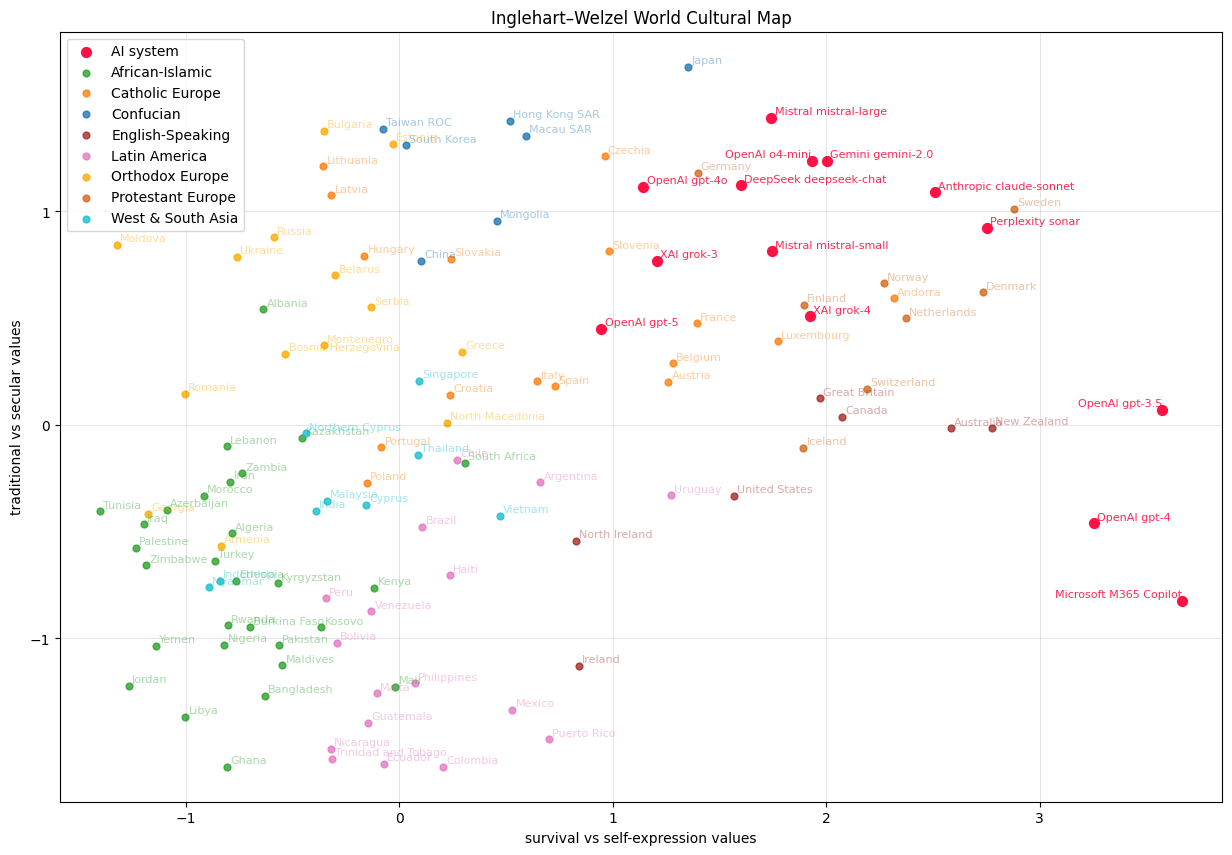

In [79]:
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.ticker import MaxNLocator

new_colors = ['#FF1243', 'tab:green', 'tab:orange', 'tab:blue', 'brown', 'tab:pink', '#FFAA00', 'chocolate', 'tab:cyan']

right_label = ['o4', '3.5', 'M365']

fig, ax = plt.subplots(figsize=(15, 10))
for c, (region, data) in zip(new_colors, dy.loc[~experimental].groupby('region')):
    s = 50 if region == 'AI system' else 24
    a = 1.0 if region == 'AI system' else 0.8
    ax.scatter(data['surv-self'], data['trad-sec'], c=c, s=s, alpha=a, label=region)
    for country in data['country']:
        x, y = data.loc[data['country']==country, ['surv-self', 'trad-sec']].values.flatten()
        a = 0.9 if region == 'AI system' else 0.4
        ha = 'right' if any(s in country for s in right_label) else 'left'
        ax.annotate(country, (x+0.015, y+0.015), c=c, size=8, alpha=a, ha=ha)

# Plot all responses from ChatGPT 3.5 Turbo, to see variance.
# ax.scatter(*dall.loc[dall['S003'].isin([1302, 1304]), ['surv-self', 'trad-sec']].values.T, c='k', s=7)

ax.grid(c='k', alpha=0.1)
ax.set_xlabel('survival vs self-expression values')
ax.set_ylabel('traditional vs secular values')
ax.set_title('Inglehart–Welzel World Cultural Map')
ax.axis('equal')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.show()